#### Install reqs

In [19]:
!pip install gym
!pip install gym[box2d]
!pip install tqdm
!pip install tensorboard
!pip install matplotlib
!pip install celluloid
!pip install ipympl
!pip install JSAnimation
!pip install einops

  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11422 sha256=caa24d99426b30fe2ea1d1f48bab7e028afe827413f200ea1340c44aef851d5a
  Stored in directory: /home/shyam/.cache/pip/wheels/ca/1c/15/0560d119ac872a47412d9f592720a771741b2ab2d51ec23baf
Successfully built JSAnimation


# Reinforce

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import tqdm
import torch.optim as optim

/home/shyam/anaconda3/envs/test_hyper_nn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from hypernn.torch.hypernet import TorchHyperNetwork

#### Target Policy Network

In [4]:
target_network = nn.Sequential(
    nn.Linear(8, 256, bias=False),
    nn.Tanh(),
    nn.Linear(256,256, bias=False),
    nn.Tanh(),
    nn.Linear(256, 4, bias=False)
)
pytorch_total_params = sum(p.numel() for p in target_network.parameters() if p.requires_grad)
pytorch_total_params

68608

#### Making a Lunar Lander Hypernetwork with a Custom Weight Generator

In [5]:
from typing import Any, Dict, List, Optional, Tuple, Type, Union  # noqa

class LunarLanderHypernetwork(TorchHyperNetwork):
    def __init__(
        self,
        target_network: nn.Module,
        num_target_parameters: Optional[int] = None,
        embedding_dim: int = 100,
        num_embeddings: int = 3,
        weight_chunk_dim: Optional[int] = None,
        custom_embedding_module: Optional[nn.Module] = None,
        custom_weight_generator: Optional[nn.Module] = None,
    ):
        super().__init__(
                    target_network = target_network,
                    num_target_parameters = num_target_parameters,
                    embedding_dim = embedding_dim,
                    num_embeddings = num_embeddings,
                    weight_chunk_dim = weight_chunk_dim,
                    custom_embedding_module = custom_embedding_module,
                    custom_weight_generator = custom_weight_generator
                )

    def make_weight_generator(self):
        return nn.Sequential(
            nn.Linear(self.embedding_dim, 32),
            nn.Tanh(),
            nn.Linear(32, self.weight_chunk_dim)
        )


### We can reduce the number of trainable parameters to less than 10%

In [6]:
EMBEDDING_DIM = 4
NUM_EMBEDDINGS = 512

hypernetwork = LunarLanderHypernetwork.from_target(
    target_network = target_network,
    embedding_dim = EMBEDDING_DIM,
    num_embeddings = NUM_EMBEDDINGS
)
pytorch_total_params = sum(p.numel() for p in hypernetwork.parameters() if p.requires_grad)
pytorch_total_params

6630

In [7]:
t = dict(target_network.named_parameters())
for n in t:
    print(n)
    print(t[n].size())

0.weight
torch.Size([256, 8])
2.weight
torch.Size([256, 256])
4.weight
torch.Size([4, 256])


In [8]:
for n in hypernetwork.target_weight_shapes:
    print(n)
    print(hypernetwork.target_weight_shapes[n])

0.weight
torch.Size([256, 8])
2.weight
torch.Size([256, 256])
4.weight
torch.Size([4, 256])


In [9]:
device = torch.device('cuda')
hypernetwork = hypernetwork.to(device)

#### Tensorboard utils

In [10]:
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

def get_tensorboard_logger(
    experiment_name: str, base_log_path: str = "tensorboard_logs"
):
    log_path = "{}/{}_{}".format(base_log_path, experiment_name, datetime.now())
    train_writer = SummaryWriter(log_path, flush_secs=10)
    full_log_path = os.path.join(os.getcwd(), log_path)
    print(
        "Follow tensorboard logs with: python -m tensorboard.main --logdir '{}'".format(full_log_path)
    )
    return train_writer


/home/shyam/anaconda3/envs/test_hyper_nn/lib/python3.9/site-packages/torch-1.11.0-py3.9-linux-x86_64.egg/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


ipympl#### Rollout function

In [11]:
import gym

def rollout(env, hypernetwork, render=False) -> float:
    with torch.no_grad():
        params, _ = hypernetwork.generate_params()
        obs = env.reset()
        done = False
        observations, actions, rewards, rendereds = [], [], [], []
        while not done:
            rendered = None
            if render:
                rendered = env.render(mode="rgb_array")
                rendereds.append(rendered)

            action_logits = hypernetwork(inp=[torch.from_numpy(obs).unsqueeze(0).to(hypernetwork.device)], generated_params=params, has_aux=False)
            dist = Categorical(logits=action_logits)
            action = dist.sample().item()
            next_obs, r, done, _ = env.step(action)

            observations.append(obs)
            actions.append(action)
            rewards.append(r)

            obs = next_obs

    env.close()
    return observations, actions, rewards, rendereds

#### Reinforce algorithm

In [12]:
def discount_reward(rews, gamma: float = 0.99):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + gamma*(rtgs[i + 1] if i + 1 < n else 0)
    return rtgs

def reinforce(
        num_epochs,
        env,
        hypernetwork,
        rollout_fn=rollout,
        lr: float = 0.001,
        gamma: float = 0.99,
    ):

    writer = get_tensorboard_logger("HypernetworkTorchRL")
    optimizer = optim.Adam(hypernetwork.parameters(), lr=lr)

    bar = tqdm.tqdm(np.arange(num_epochs))
    for i in bar:
        observations, actions, rewards, _ = rollout_fn(env, hypernetwork)

        discounted_rewards = discount_reward(np.array(rewards), gamma)
        discounted_rewards = discounted_rewards - np.mean(discounted_rewards)
        discounted_rewards = discounted_rewards / (
            np.std(discounted_rewards) + 1e-10
        )

        observations = torch.from_numpy(np.array(observations)).float().to(hypernetwork.device)
        actions = torch.from_numpy(np.array(actions)).float().to(hypernetwork.device)
        discounted_rewards = torch.from_numpy(discounted_rewards).float().to(hypernetwork.device)

        logits, generated_params, aux_output = hypernetwork(inp=[observations], has_aux=True)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions)

        optimizer.zero_grad()
        loss = -1 * torch.sum(discounted_rewards * log_probs)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(hypernetwork.parameters(), 100.0)
        optimizer.step()

        grad_dict = {}
        for n, W in hypernetwork.named_parameters():
            if W.grad is not None:
                grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

        metrics = {"loss":loss.item(), "rewards":np.sum(rewards), **grad_dict}

        for key in metrics:
            writer.add_scalar(key, metrics[key], i)

        bar.set_description('Loss: {}, Sum Reward: {}'.format(loss.item(), np.sum(rewards)))

In [13]:
env = gym.make("LunarLander-v2")

In [14]:
reinforce(5000, env, hypernetwork, lr=0.0002)

Follow tensorboard logs with: python -m tensorboard.main --logdir '/home/shyam/Code/hyper-nn/notebooks/reinforce/tensorboard_logs/HypernetworkTorchRL_2022-05-30 11:07:04.353466'


Loss: 26.958415985107422, Sum Reward: 103.6341627833736:  13%|▉      | 656/5000 [07:23<48:57,  1.48it/s]


KeyboardInterrupt: 

In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib ipympl

plt.style.use('ggplot')
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from celluloid import Camera
from IPython.display import HTML


def render_rollout(model):
    fig = plt.figure("Animation",figsize=(7,5))
    camera = Camera(fig)
    ax = fig.add_subplot(111)
    _, _, rewards, rendereds = rollout(gym.make("LunarLander-v2"), model, render=True)
    frames = []
    for r in rendereds:
        frame = ax.imshow(r)
        ax.axis('off')
        camera.snap()
        frames.append([frame])
    print("Sum Reward: {}".format(np.sum(rewards)))
    animation = camera.animate(blit=False, interval=50)
    # display(animations.to_html5_video())
    animation.save('HyperTorchLunarLander.mp4')
    return animation

/home/shyam/anaconda3/envs/test_hyper_nn/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


Sum Reward: 95.26586962876422


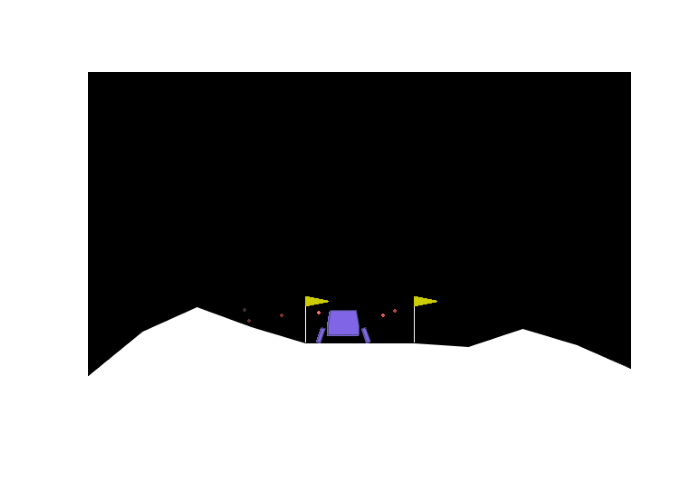

In [21]:
vid = render_rollout(hypernetwork)

##### Play video

In [22]:
from IPython.display import Video

Video("HyperTorchLunarLander.mp4")